Load modules/packages.

In [27]:
import pygam
import pandas
import numpy
import numpy.random
import seaborn
import matplotlib.pyplot 
import vtreat
import vtreat.util
import wvpy.util

Generate example data.

In [28]:
d = pandas.DataFrame({'x':[0.1*i for i in range(500)]})
d['y'] = numpy.sin(d['x']) + 0.1*numpy.random.normal(size=d.shape[0])
d['xc'] = ['level_' + str(5*numpy.round(yi/5, 1)) for yi in d['y']]
d['yc'] = d['y']>0.5
d.head()

,x,y,xc,yc
0,0.0,0.038079,level_0.0,False
1,0.1,0.158607,level_0.0,False
2,0.2,0.236051,level_0.0,False
3,0.3,0.212349,level_0.0,False
4,0.4,0.485296,level_0.5,False


In [29]:
numpy.mean(d['yc'])

0.324

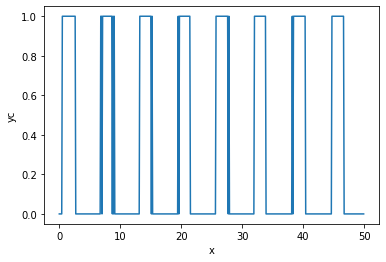

In [30]:
seaborn.lineplot(x='x', y='yc', data=d)

Build a classification model.

In [31]:
transform = vtreat.BinomialOutcomeTreatment(
    outcome_name='yc', 
    outcome_target=True,
    cols_to_copy=['y'])

In [32]:
d_prepared = transform.fit_transform(d, d['yc'])
d_prepared.head()

,y,yc,x,xc_logit_code,xc_prevalence_code,xc_lev_level_1.0,xc_lev_level_-1.0,xc_lev_level_-0.5,xc_lev_level_0.5
0,0.038079,False,0.0,-5.798845,0.078,0,0,0,0
1,0.158607,False,0.1,-5.664618,0.078,0,0,0,0
2,0.236051,False,0.2,-5.664618,0.078,0,0,0,0
3,0.212349,False,0.3,-5.694213,0.078,0,0,0,0
4,0.485296,False,0.4,0.458916,0.188,0,0,0,1


In [33]:
transform.score_frame_

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,vcount,recommended
0,x,x,clean_copy,False,True,-0.075233,9.287172e-02,1.0,True
1,xc_logit_code,xc,logit_code,True,True,0.836146,5.534165e-132,1.0,True
2,xc_prevalence_code,xc,prevalence_code,False,True,0.415484,2.742704e-22,1.0,True
3,xc_lev_level_1.0,xc,indicator_code,False,True,0.789440,1.265324e-107,4.0,True
4,xc_lev_level_-1.0,xc,indicator_code,False,True,-0.369816,1.191412e-17,4.0,True
5,xc_lev_level_-0.5,xc,indicator_code,False,True,-0.335300,1.330458e-14,4.0,True
6,xc_lev_level_0.5,xc,indicator_code,False,True,0.176692,7.116705e-05,4.0,True


Look at `xc_logit_code`.

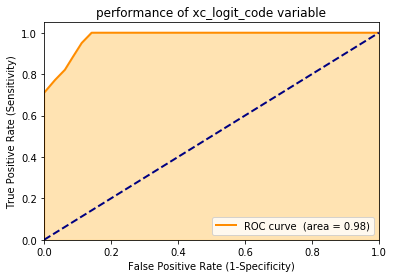

0.9790799181824823

In [34]:
wvpy.util.plot_roc(prediction=d_prepared['xc_logit_code'], 
                   istrue=d_prepared['yc'],
                   title = 'performance of xc_logit_code variable')

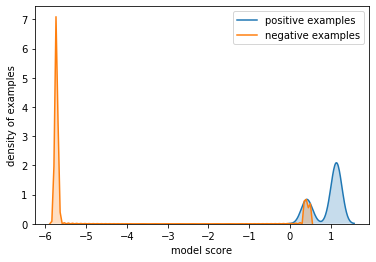

In [35]:
wvpy.util.dual_density_plot(probs=d_prepared['xc_logit_code'], 
                            istrue=d_prepared['yc'])

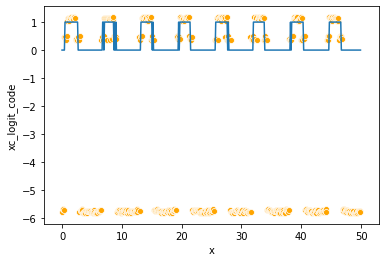

In [36]:
seaborn.lineplot(x='x', y='yc', data=d_prepared)
seaborn.scatterplot(x='x', y='xc_logit_code', data=d_prepared, 
                    color='orange')

Look at `xc_prevalence_code`.

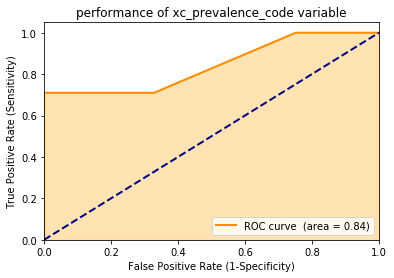

0.8433505004017825

In [37]:
wvpy.util.plot_roc(prediction=d_prepared['xc_prevalence_code'], 
                   istrue=d_prepared['yc'],
                   title = 'performance of xc_prevalence_code variable')

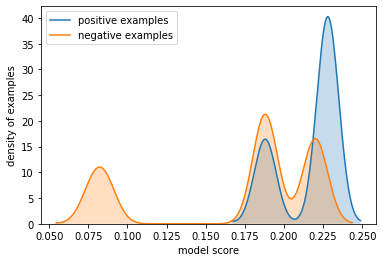

In [38]:
wvpy.util.dual_density_plot(probs=d_prepared['xc_prevalence_code'], 
                            istrue=d_prepared['yc'])

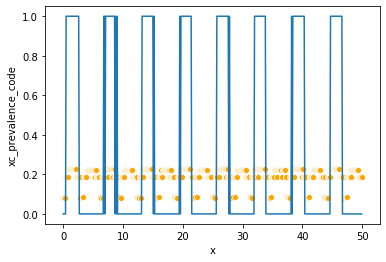

In [39]:
seaborn.lineplot(x='x', y='yc', data=d_prepared)
seaborn.scatterplot(x='x', y='xc_prevalence_code', data=d_prepared, 
                    color='orange')